# Image Caption BLIP-2: A new Visual Language Model # 

BLIP-2 is a new visual language model (VLM) capable of multimodal tasks like captioning, visual dialogue and visual question answering.

* BLIP-2 stands for Bootstrapping Language-Image Pre-training with frozen unimodal models.

* In previous approaches we used pre-trained unimodal models for Vision-language pre-training (VLP). This requires aligning visual and textual features, which can be challenging. This is particularly true for frozen unimodal models (like LLMs), which have not seen any images during their pre-training. BLIP address this problem, by introducing a lightweight module called Querying Transformer (Q-Former) that effectively enhances the vision-language model.

* Q-Former is a lightweight transformer that uses learnable query vectors to extract visual features from the frozen image encoder. It acts as an information bottleneck between the frozen image encoder and the frozen LLM, where it feeds the most useful visual feature for the LLM to output the desired text. 

* Key ideas of BLIP-2:

![Merge Architecture for Encoder-Decoder Model](..\images\BLIP-2.png)

In [2]:
import src.utils as plh

PROJECT_ROOT = plh.get_project_root()

## Create dataset ##

In [1]:
from datasets import Dataset
from datasets import Image
import pandas as pd
import os

In [3]:
base_path = os.path.join(PROJECT_ROOT, 'data', 'processed')
image_base_path = os.path.join(PROJECT_ROOT, 'data', 'images')

In [36]:
train_db = pd.read_parquet(os.path.join(base_path, 'train_data_processed.parquet'))

image_paths = list(image_base_path + '/' + train_db["image_name"])
captions = list(train_db["caption"])

train_db = Dataset.from_dict(
                            {
                                "image": image_paths,
                                "text": captions,
                            }
                        ).cast_column("image", Image())

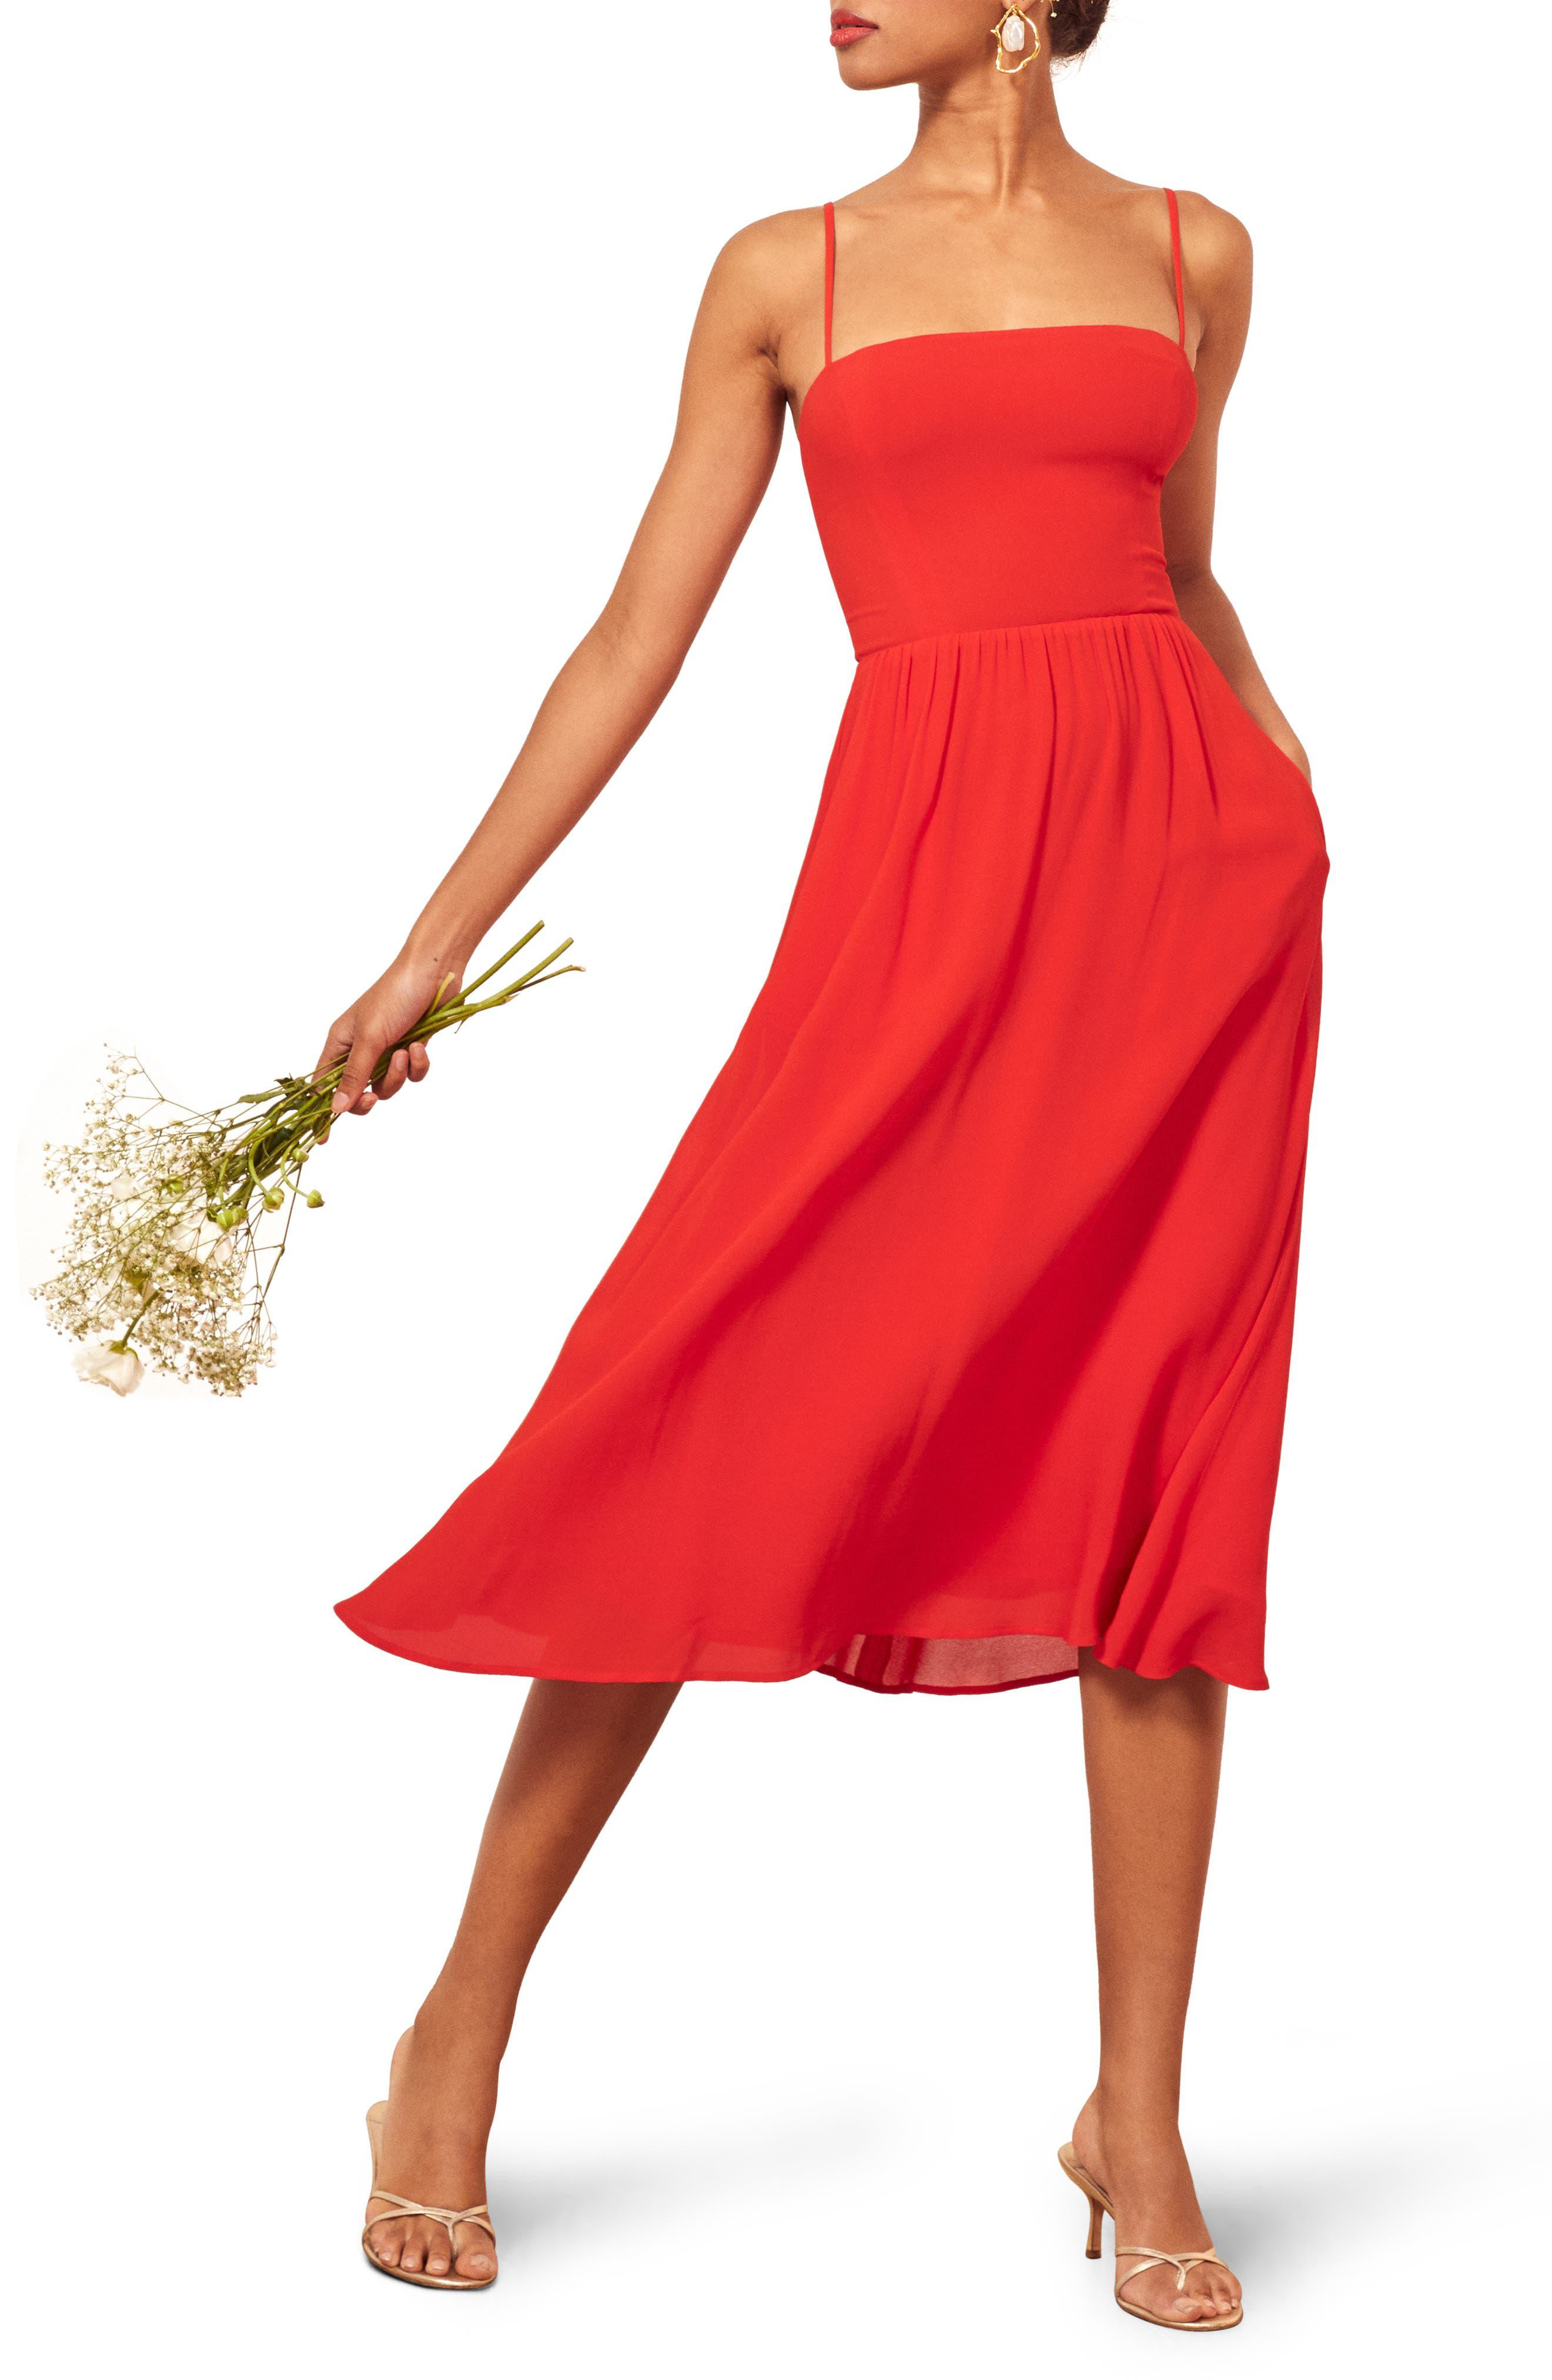

In [37]:
train_db[0]["image"]

In [27]:
valid_db = pd.read_parquet(os.path.join(base_path, 'validate_data_processed.parquet'))

image_paths = list(image_base_path + '/' + valid_db["image_name"])
captions = list(valid_db["caption"])

valid_db = Dataset.from_dict(
                            {
                                "image": image_paths,
                                "text": captions,
                            }
                        ).cast_column("image", Image())

In [29]:
import gc

del [captions, image_paths]
gc.collect()

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        item = self.dataset[idx]
        encoding = self.processor(images = item["image"], text = item["text"], padding = "max_length", return_tensors = "pt")
       
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor ##

In [ ]:
#https://huggingface.co/Salesforce/blip2-opt-2.7b

checkpoint = "Salesforce/blip2-opt-2.7b"

In [ ]:
#https://huggingface.co/docs/transformers/model_doc/blip-2

from transformers import  Blip2ForConditionalGeneration
from transformers import Blip2Processor

processor = Blip2Processor.from_pretrained(checkpoint)
model = Blip2ForConditionalGeneration.from_pretrained(checkpoint)

## Train the model ##

In [38]:
BATCH_SIZE = 64
Lr = 5e-5

In [ ]:
train_db = ImageCaptioningDataset(train_db, processor)
train_db = DataLoader(train_db, shuffle = True, batch_size = BATCH_SIZE)

In [ ]:
valid_db = ImageCaptioningDataset(valid_db, processor)
valid_db = DataLoader(valid_db, shuffle = True, batch_size = BATCH_SIZE)

In [ ]:
import torch

devices = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(devices)
model.train()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr = Lr)

In [ ]:
%%time
#Code Refer: https://github.com/huggingface/notebooks/blob/main/examples/image_captioning_blip.ipynb

from tqdm.auto import tqdm

EPOCH = 10
progress_bar = tqdm(range(EPOCH))
train_loss = {}

for epoch in range(EPOCH):
    epoch_loss = []  
    print("Epoch:", epoch)

    for idx, batch in enumerate(train_db):
        
        input_ids = batch.pop("input_ids").to(devices)
        pixel_values = batch.pop("pixel_values").to(devices)

        outputs = model(input_ids = input_ids,
                        pixel_values = pixel_values,
                        labels = input_ids)

        loss = outputs.loss
        epoch_loss.append(loss)

        if idx%10 == 0:
            print(f"Batch:{idx}, Loss: {loss.item()}")

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    train_loss[epoch] = epoch_loss

In [1]:
from transformers import Blip2ForConditionalGeneration

In [2]:
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", 
                                                       device_map = "auto", 
                                                       torch_dtype = "auto",
                                                       offload_folder = "offload_model", 
                                                       offload_state_dict = True,
                                                    )

f:\github_workspace\fashion_image_caption\.env\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\smithau8\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
filename = r'F:\github_workspace\fashion_image_caption\data\blip2_model'
model.save_pretrained(
                filename,
                max_shard_size = "3GB",                
            )